# SETTING UP THE ENV

Lets impot Libraries

In [1]:
#download necessary libraries

!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/kaggle/working')
# !ls /kaggle/working
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.2
12.1


In [3]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax
from sklearn.metrics import r2_score

# Pre Processing

In [5]:
df = pd.read_csv('/kaggle/input/cms-dataset/CMS_trigger.csv')
print(df.columns)

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle'],
      dtype='object')


In [6]:
df.head()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
0,0,58.066666,55.466667,55.466667,56.000000,11.970,11.684999,11.400,11.400,-13.000000,...,0.0,0.0,0.0,0.0,5.0,3.0,105.0,0.181209,-3.075936,1.722345
1,1,64.583336,66.800000,67.066666,67.200000,6.555,6.840000,6.555,6.840,7.000000,...,0.0,0.0,0.0,0.0,3.0,1.0,124.0,-0.146131,-0.167139,2.012122
2,2,71.150000,67.033330,66.266670,65.466670,2.850,2.565000,2.280,2.280,-16.613783,...,0.0,0.0,0.0,0.0,7.0,0.0,127.0,0.367024,2.431823,2.321646
3,3,34.933334,31.200000,31.200000,31.833334,9.690,8.835000,8.835,9.120,-13.000000,...,0.0,0.0,0.0,0.0,6.0,2.0,60.0,0.267774,-1.343305,1.854506
4,4,68.150000,68.266670,68.300000,68.400000,2.565,2.565000,2.565,2.565,0.000000,...,0.0,0.0,0.0,0.0,4.0,0.0,128.0,-0.019179,-3.134433,2.333772


In [7]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,4.851559e+01,4.851127e+01,4.851076e+01,4.851331e+01,6.195453e+00,5.918753e+00,5.848332e+00,5.881490e+00,5.603115e-02,...,0.0,0.0,0.0,0.0,3.976490e+00,1.080514e+00,9.115961e+01,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.774647e+01,1.779697e+01,1.781670e+01,1.779750e+01,3.011983e+00,2.921076e+00,2.911875e+00,2.906416e+00,1.493805e+01,...,0.0,0.0,0.0,0.0,1.871622e+00,1.089190e+00,3.328909e+01,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,1.103333e+01,2.400000e+00,2.666667e+00,2.666667e+00,1.425000e+00,1.425000e+00,1.425000e+00,1.710000e+00,-1.329103e+02,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.000000e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,3.371667e+01,3.360000e+01,3.360000e+01,3.360000e+01,3.705000e+00,3.420000e+00,3.420000e+00,3.420000e+00,-1.100000e+01,...,0.0,0.0,0.0,0.0,3.000000e+00,0.000000e+00,6.300000e+01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,4.830000e+01,4.826667e+01,4.826667e+01,4.826667e+01,5.700000e+00,5.415000e+00,5.415000e+00,5.415000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,4.000000e+00,1.000000e+00,9.100000e+01,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,6.326667e+01,6.303333e+01,6.293333e+01,6.296667e+01,8.265000e+00,7.980000e+00,7.695000e+00,7.980000e+00,1.100000e+01,...,0.0,0.0,0.0,0.0,5.000000e+00,2.000000e+00,1.180000e+02,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,8.311667e+01,8.256667e+01,8.253333e+01,8.253333e+01,1.510500e+01,1.396500e+01,1.539000e+01,1.510500e+01,1.421401e+02,...,0.0,0.0,0.0,0.0,8.000000e+00,4.000000e+00,1.540000e+02,4.999991e-01,3.141592e+00,2.493834e+00


In [8]:
#HOW MOMENTUM NEGATIVE??

**The data is not scaled, so we would have to scale the data first before we proceed to train a model on the data**

**To begin with lets  scale the data by using Standard Scalar**

In [9]:
scaler = StandardScaler()

In [10]:
df.loc[:,"Phi_0":"MedianTheta"] = scaler.fit_transform(df.loc[:,"Phi_0":"MedianTheta"])

In [11]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,7.146661e-17,-2.706296e-16,-7.705465e-16,-3.355171e-16,-2.781065e-16,8.641905e-16,6.533453e-16,3.205695e-16,2.842518e-17,...,0.0,0.0,0.0,0.0,-4.221603e-17,-8.916758e-18,1.504040e-16,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.0,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,-2.112098e+00,-2.590963e+00,-2.573098e+00,-2.576017e+00,-1.583825e+00,-1.538390e+00,-1.519067e+00,-1.435270e+00,-8.901182e+00,...,0.0,0.0,0.0,0.0,-2.124623e+00,-9.920352e-01,-2.498105e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,-8.339083e-01,-8.378547e-01,-8.368982e-01,-8.379445e-01,-8.268486e-01,-8.554224e-01,-8.339413e-01,-8.469162e-01,-7.401255e-01,...,0.0,0.0,0.0,0.0,-5.217347e-01,-9.920352e-01,-8.459116e-01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,-1.214813e-02,-1.374387e-02,-1.370004e-02,-1.385850e-02,-1.644940e-01,-1.724547e-01,-1.488154e-01,-1.605036e-01,-3.750902e-03,...,0.0,0.0,0.0,0.0,1.256146e-02,-7.392128e-02,-4.794768e-03,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,8.312126e-01,8.159859e-01,8.094982e-01,8.121005e-01,6.871047e-01,7.056466e-01,6.341855e-01,7.220270e-01,7.326237e-01,...,0.0,0.0,0.0,0.0,5.468577e-01,8.441926e-01,8.062822e-01,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,1.949746e+00,1.913552e+00,1.909590e+00,1.911506e+00,2.958035e+00,2.754550e+00,3.276814e+00,3.173501e+00,9.511558e+00,...,0.0,0.0,0.0,0.0,2.149746e+00,2.680420e+00,1.887718e+00,4.999991e-01,3.141592e+00,2.493834e+00


**We can see that the std dev and the mean has been transformed to 1 and 0 respectively**

In [12]:
features = list(df.columns)[1:29]
features

['Phi_0',
 'Phi_2',
 'Phi_3',
 'Phi_4',
 'Theta_0',
 'Theta_2',
 'Theta_3',
 'Theta_4',
 'BendingAngle_0',
 'BendingAngle_2',
 'BendingAngle_3',
 'BendingAngle_4',
 'TimeInfo_0',
 'TimeInfo_2',
 'TimeInfo_3',
 'TimeInfo_4',
 'RingNumber_0',
 'RingNumber_2',
 'RingNumber_3',
 'RingNumber_4',
 'Front_0',
 'Front_2',
 'Front_3',
 'Front_4',
 'Mask_0',
 'Mask_2',
 'Mask_3',
 'Mask_4']

In [13]:
# Lets split the data into train and the test splits

In [14]:
train_idx, test_idx = train_test_split(df['Unnamed: 0'].to_numpy(), test_size = 0.2, random_state = 1)
x_data = df[features].to_numpy()
pT = abs(1/df.loc[:,'q/pt']).to_numpy()
label = pT
num_features = x_data.shape[-1]
print('Data shape: ' + str(x_data.shape))
print(pT.shape)
print('Len train: '+str(len(train_idx))+', Len test: '+str(len(test_idx)))
print('Num. features: '+str(num_features))

Data shape: (1179356, 28)
(1179356,)
Len train: 943484, Len test: 235872
Num. features: 28


In [15]:
label.min(), label.max()

(2.00000380000722, 6955.5709428241635)

# Dataset Class and Data Loaders

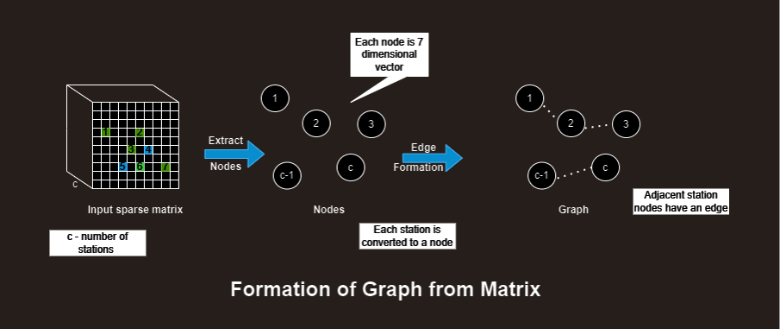

**The dataset is having 28 features extracted from 4 triggers ie 7 features per trigger**

**Total approached to try**

---------------------------------------------------------------------------------------------------------------------------
**(THIS NOTEBOOK)**

- [x] **Each station as a node : 
    Here basically each station(4),is made a node of the graph and the node feature is the features recieved at the respective station(7)**
    
    Here,
         Total nodes = 4
         node feature length = 7
         edges should be between these 4 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
    
    
---------------------------------------------------------------------------------------------------------------------------
- [ ] **Each feature as a node :
    Here basically each feature obtianed from different stations, here 4 stations are made a node of the graph and 
    the node feature is the values of this feature across the 4 different stations**
    
    Here,
         Total nodes = 7
         node feature length = 4
         edges should be between these 7 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
         
---------------------------------------------------------------------------------------------------------------------------

- [ ]  **Each patch as a node :
    Here basically the data is converted into 7*4 matrix and then would have to split this into patches and then the features of the noden would be the flattened pixel values in each patch**
    
    Here,
         Total nodes = total_patches 
         node feature length = pixels in each path
         edges should be between these patch nodes (Yet to find out the best way to decide across which two nodes there should be and edge
         
---------------------------------------------------------------------------------------------------------------------------

In [16]:
# x_data.shape

In [17]:
class Graph_dataset(Dataset):
    def __init__(self, dataset , label,  edge_index, indices, transform=None):
        self.transform = transform
        self.data = dataset
        self.edge_index = edge_index
        self.indices = indices
        self.label = label
    
    def __getitem__(self, idx):
        return self.convert_to_graph(self.indices[idx])
    
    def __len__(self):
        return len(self.indices)
    
    def convert_to_graph(self, i):
    
        data = Data(x=torch.tensor(self.data[i].reshape(-1,4).T, dtype=torch.float), y=torch.tensor(self.label[i], dtype=torch.float),
                    edge_index=torch.tensor(self.edge_index, dtype = torch.long).T)
        return data

In [18]:
edge_index = [(0,1),(1,2),(2,3),(3,2),(2,1),(1,0)]

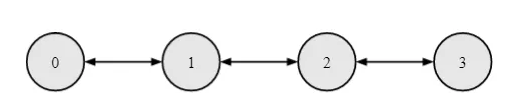

In [19]:
train_dataset = Graph_dataset(x_data, label, edge_index , train_idx)
next(iter(train_dataset))

Data(x=[4, 7], edge_index=[2, 6], y=9.726032257080078)

In [20]:
train_loader = DataLoader(Graph_dataset(x_data, label, edge_index , train_idx), batch_size=1024)
test_loader = DataLoader(Graph_dataset(x_data, label, edge_index , test_idx), batch_size=512)

In [21]:
next(iter(train_loader))

DataBatch(x=[4096, 7], edge_index=[2, 6144], y=[1024], batch=[4096], ptr=[1025])

**We are all set with the dataset and the dataloader**

# Lets set the Model

In [22]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import to_dense_batch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class MODEL_GNN(torch.nn.Module):
    def __init__(self):
        super(MODEL_GNN, self).__init__()
        self.conv1 = GCNConv(int(len(features)/4),128 )
        self.conv2 = GCNConv(128,64)
        self.conv3 = GCNConv(64,64 )
        self.conv4 = GCNConv(64,64 )
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 16)
        self.lin3 = torch.nn.Linear(16, 16)
        self.lin4 = torch.nn.Linear(16, 1)
        self.lin5 = torch.nn.Linear(128, 128)
        self.lin6 = torch.nn.Linear(128, 16)
        self.lin7 = torch.nn.Linear(16, 16)
        self.lin8 = torch.nn.Linear(16, 1)
        self.global_att_pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
        self.global_att_pool2 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x1 = self.global_att_pool1(x, batch)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x2 = self.global_att_pool2(x, batch)
        x_out = torch.cat([x1, x2], dim=1)
        x = F.relu(self.lin1(x_out))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.lin4(x).squeeze(1)

        return x

In [24]:
# Example usage:
# Initialize your model
model = MODEL_GNN()

In [25]:
model

MODEL_GNN(
  (conv1): GCNConv(7, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (lin5): Linear(in_features=128, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_features=16, bias=True)
  (lin7): Linear(in_features=16, out_features=16, bias=True)
  (lin8): Linear(in_features=16, out_features=1, bias=True)
  (global_att_pool1): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
  (global_att_pool2): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
)

In [26]:
# Forward pass with input data x and edge_index

In [27]:
def train(train_loader, test_loader, prog_bar = True):
    
    train_losses, test_losses = list(), list()
    min_test_loss = float('inf')
#     criterion = nn.MSELoss()
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            loss.backward()
            optimizer.step()
            if prog_bar:
                pbar.set_description('MSEError: '+str(loss.cpu().detach().numpy()))
                train_loss += loss.cpu().detach().numpy()/len(train_loader)
                
        # test
        for data in test_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
        if test_loss<min_test_loss:
            print('Min loss changed from '+str(min_test_loss)+' to '+str(test_loss))
            min_test_loss = test_loss
            torch.save(model.state_dict(), model_name)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch > 10 and min(test_losses[-7:])>min_test_loss+1e-9:
            break
        lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training pTLoss: ', train_loss, '| Testing pTLoss: ', test_loss)
        
        if prog_bar:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses, label="Validation Loss")
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
    return train_losses, test_losses

In [28]:
def pTLossTorch(y_pred,y_true):
#     if not inv:
#         y_pred = torch.pow(y_pred,-1)
#         y_true = torch.pow(y_true,-1)
    y_t = (y_true<80).type(torch.FloatTensor)*y_true.type(torch.FloatTensor) + (y_true>=80).type(torch.FloatTensor)*(y_true<250).type(torch.FloatTensor)*y_true.type(torch.FloatTensor)**2.4 + (y_true>=160).type(torch.FloatTensor)*10 
    return torch.mean(y_t.type(torch.FloatTensor)*torch.pow((y_pred-y_true)/y_true,2).type(torch.FloatTensor))/250

In [29]:
name =  f"4GCN_Conv"

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from inf to 4.9099070968958936
Epoch:  1/50 | Training pTLoss:  7.168252501467046 | Testing pTLoss:  4.9099070968958936


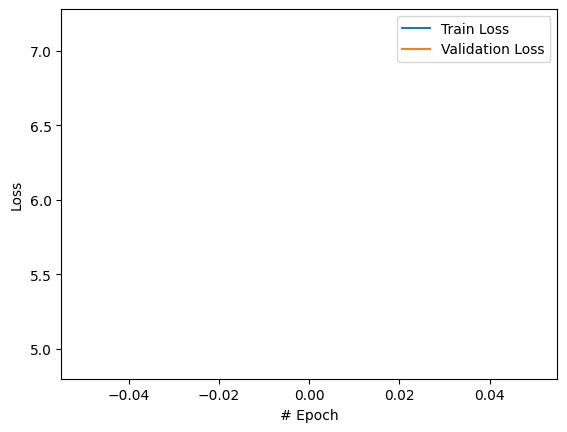

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.9099070968958936 to 4.370818222939581
Epoch:  2/50 | Training pTLoss:  4.833751939511869 | Testing pTLoss:  4.370818222939581


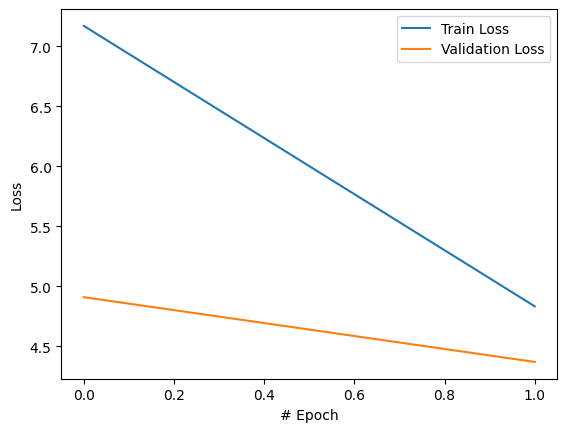

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.370818222939581 to 4.050630648068904
Epoch:  3/50 | Training pTLoss:  4.322179128187594 | Testing pTLoss:  4.050630648068904


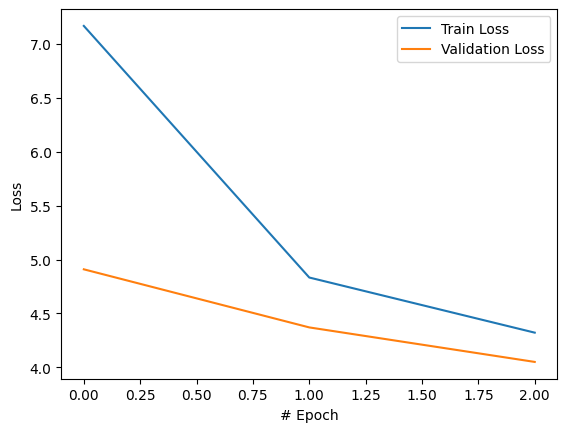

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.050630648068904 to 4.043320299487826
Epoch:  4/50 | Training pTLoss:  4.164348058095463 | Testing pTLoss:  4.043320299487826


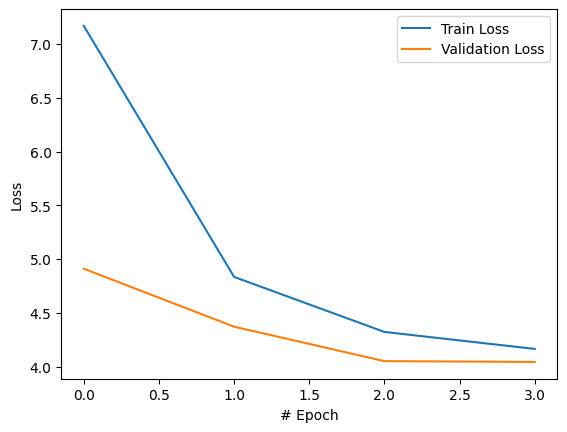

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  5/50 | Training pTLoss:  4.128795089018326 | Testing pTLoss:  4.045621878930132


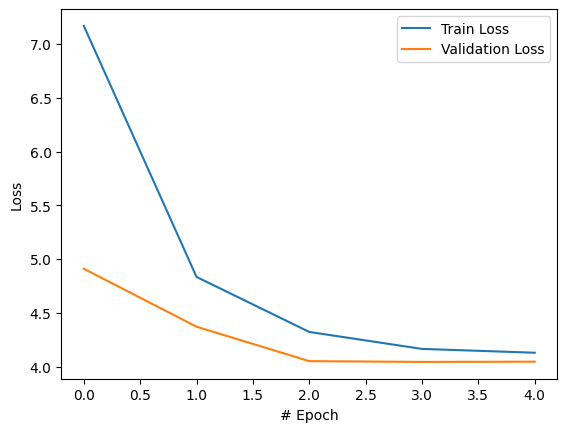

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.043320299487826 to 4.029432826342139
Epoch:  6/50 | Training pTLoss:  4.102546969230677 | Testing pTLoss:  4.029432826342139


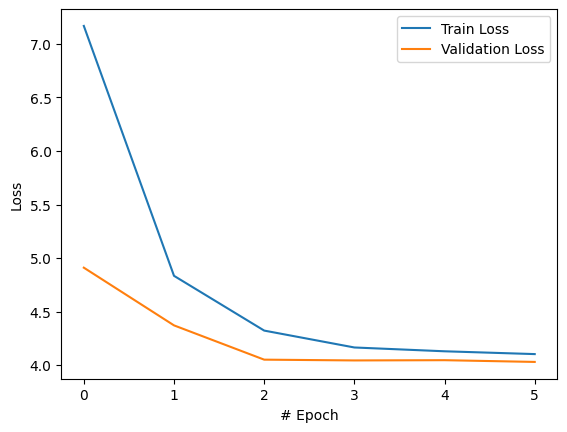

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.029432826342139 to 4.019737557061579
Epoch:  7/50 | Training pTLoss:  4.088573274022838 | Testing pTLoss:  4.019737557061579


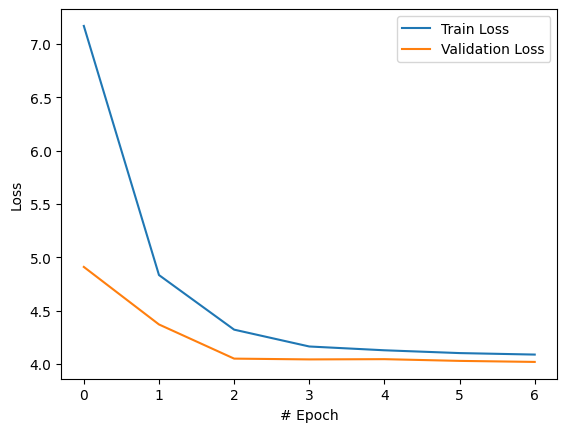

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.019737557061579 to 4.015971584847593
Epoch:  8/50 | Training pTLoss:  4.077678118377858 | Testing pTLoss:  4.015971584847593


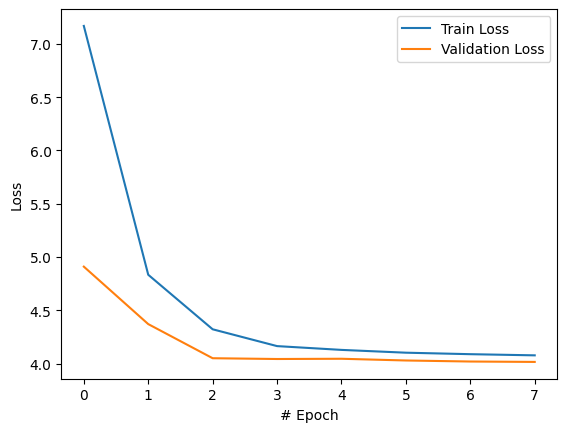

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.015971584847593 to 3.9881417637533287
Epoch:  9/50 | Training pTLoss:  4.065788713944454 | Testing pTLoss:  3.9881417637533287


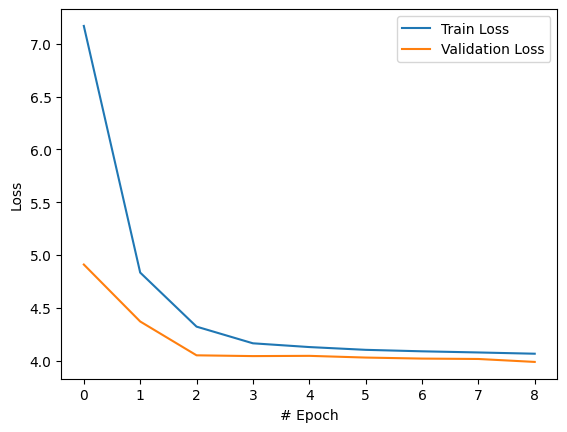

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  10/50 | Training pTLoss:  4.05722993353701 | Testing pTLoss:  4.004107498036548


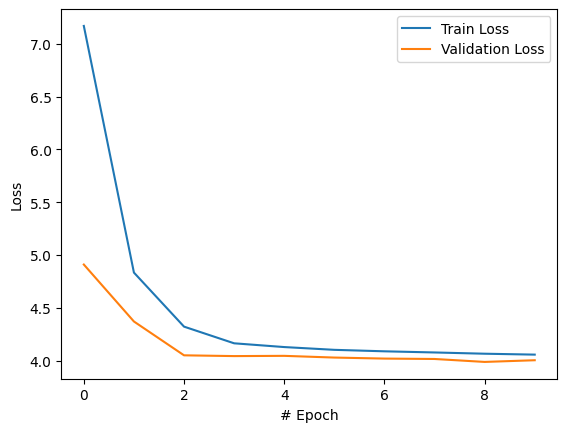

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  11/50 | Training pTLoss:  4.045076254908796 | Testing pTLoss:  4.008408936657773


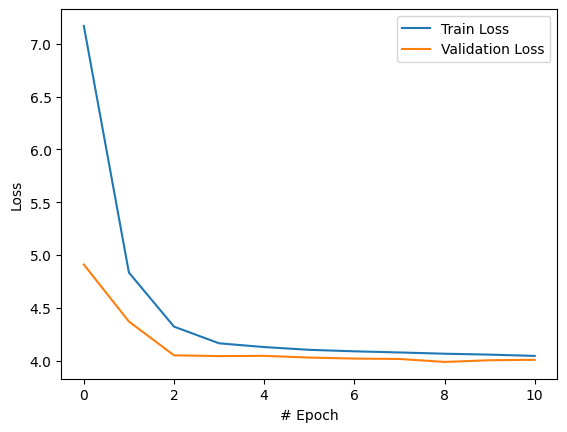

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.9881417637533287 to 3.916109749138232
Epoch:  12/50 | Training pTLoss:  4.002294101839217 | Testing pTLoss:  3.916109749138232


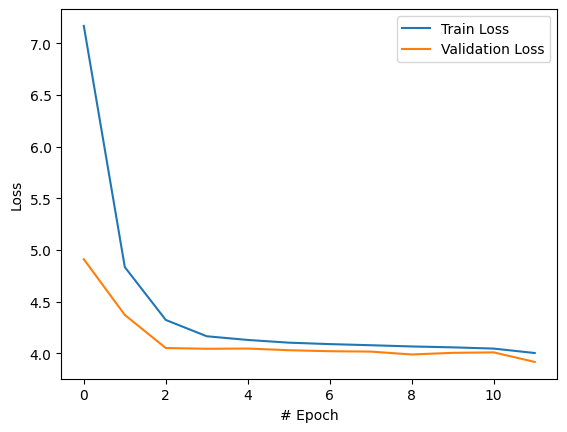

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.916109749138232 to 3.9136888106836434
Epoch:  13/50 | Training pTLoss:  3.9963929848401962 | Testing pTLoss:  3.9136888106836434


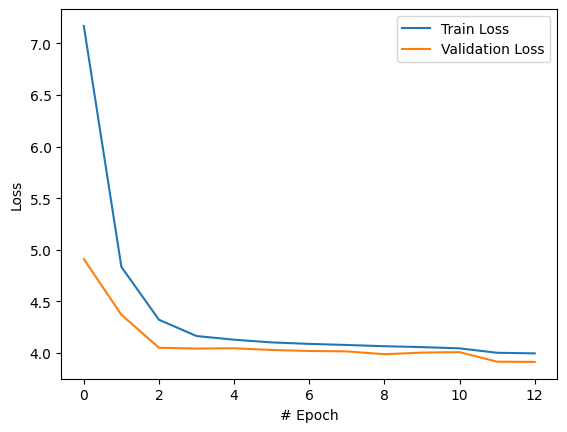

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  14/50 | Training pTLoss:  3.991942397167264 | Testing pTLoss:  3.913918402603546


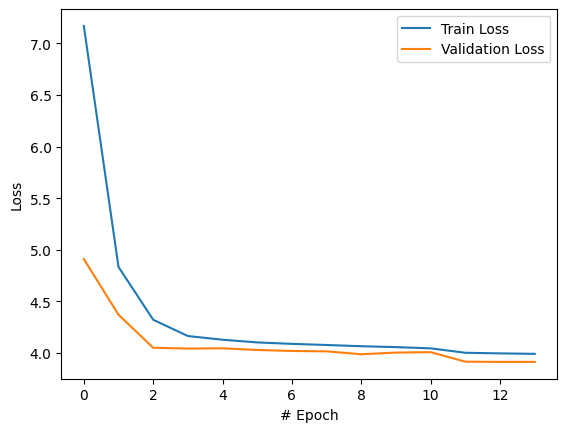

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.9136888106836434 to 3.9078780384229166
Epoch:  15/50 | Training pTLoss:  3.9880504361202322 | Testing pTLoss:  3.9078780384229166


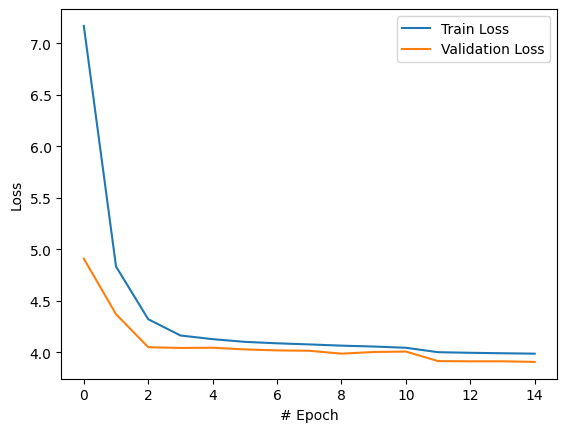

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.9078780384229166 to 3.9042339875744636
Epoch:  16/50 | Training pTLoss:  3.983366937802826 | Testing pTLoss:  3.9042339875744636


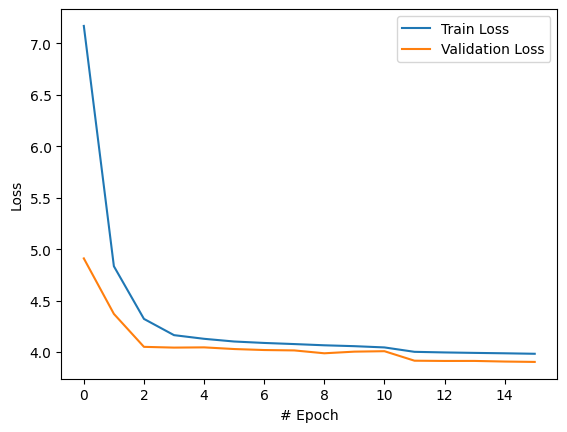

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  17/50 | Training pTLoss:  3.9802315837649083 | Testing pTLoss:  3.9067266377864844


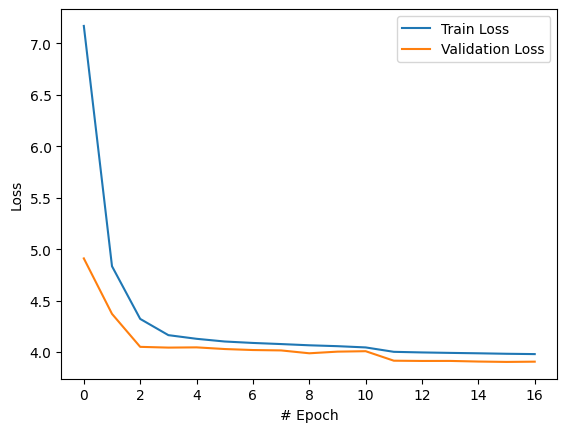

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  18/50 | Training pTLoss:  3.9774642672042324 | Testing pTLoss:  3.904541375062987


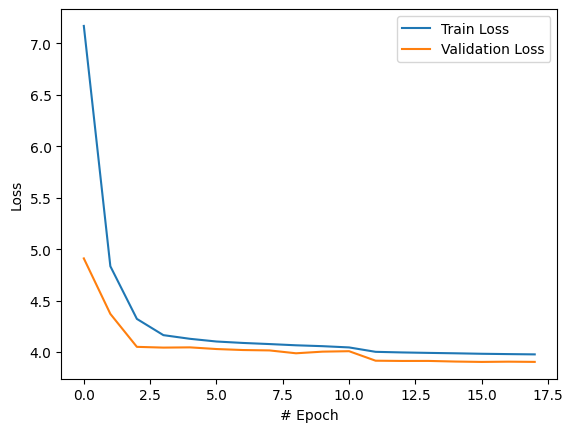

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.9042339875744636 to 3.87224044122303
Epoch:  19/50 | Training pTLoss:  3.950412593151642 | Testing pTLoss:  3.87224044122303


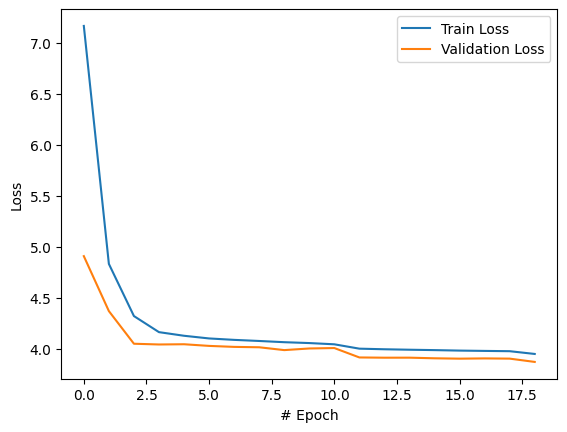

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.87224044122303 to 3.871792084741489
Epoch:  20/50 | Training pTLoss:  3.947157935310083 | Testing pTLoss:  3.871792084741489


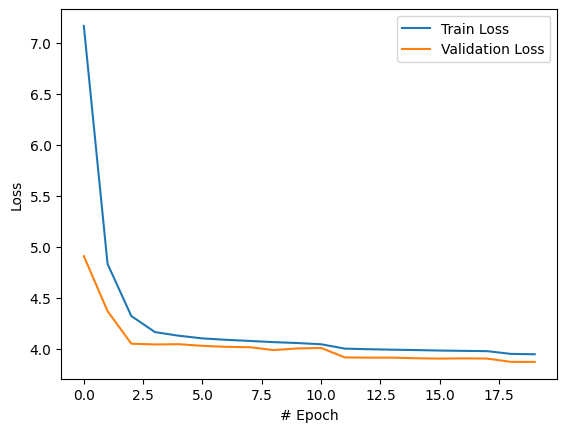

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  21/50 | Training pTLoss:  3.9446668306814083 | Testing pTLoss:  3.8725942957685735


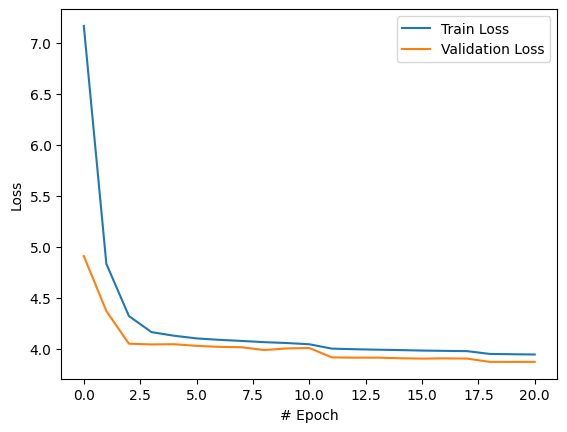

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  22/50 | Training pTLoss:  3.942940269013027 | Testing pTLoss:  3.8722489177534225


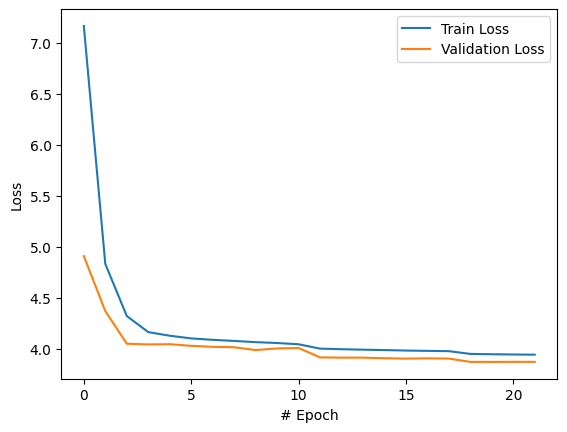

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.871792084741489 to 3.8544288612498097
Epoch:  23/50 | Training pTLoss:  3.9268470088468486 | Testing pTLoss:  3.8544288612498097


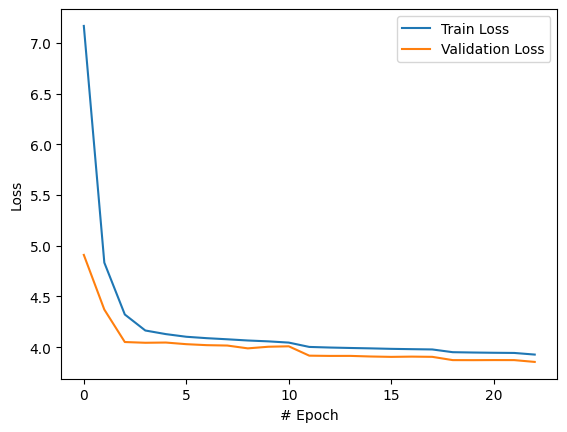

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  24/50 | Training pTLoss:  3.924539818551686 | Testing pTLoss:  3.854502720325989


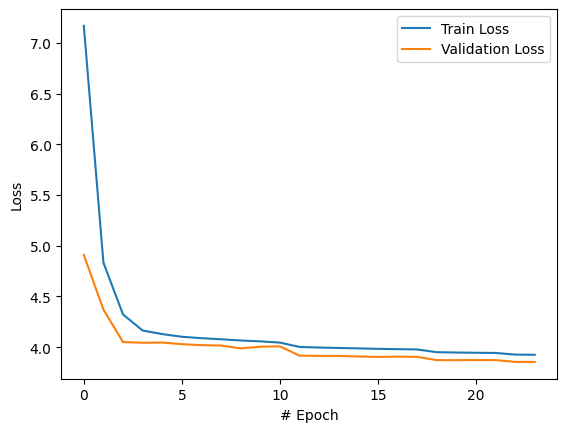

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8544288612498097 to 3.8544065890239785
Epoch 00025: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  25/50 | Training pTLoss:  3.9233891335588695 | Testing pTLoss:  3.8544065890239785


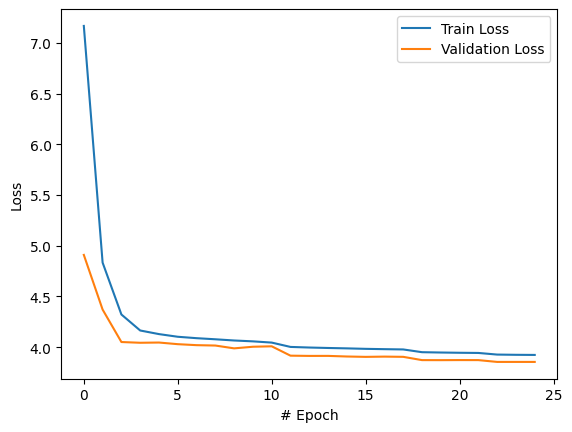

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8544065890239785 to 3.8451774991774035
Epoch:  26/50 | Training pTLoss:  3.914343481855127 | Testing pTLoss:  3.8451774991774035


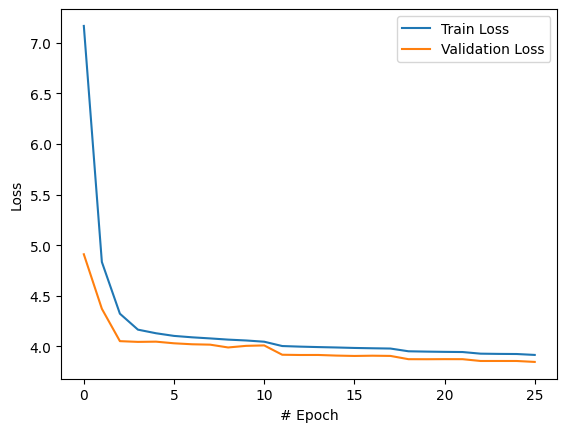

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8451774991774035 to 3.844924931412405
Epoch:  27/50 | Training pTLoss:  3.9129941919879148 | Testing pTLoss:  3.844924931412405


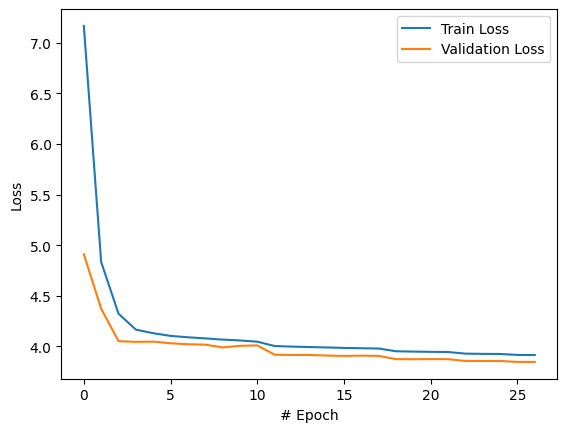

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.844924931412405 to 3.8448960597499595
Epoch 00028: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  28/50 | Training pTLoss:  3.9122645001608025 | Testing pTLoss:  3.8448960597499595


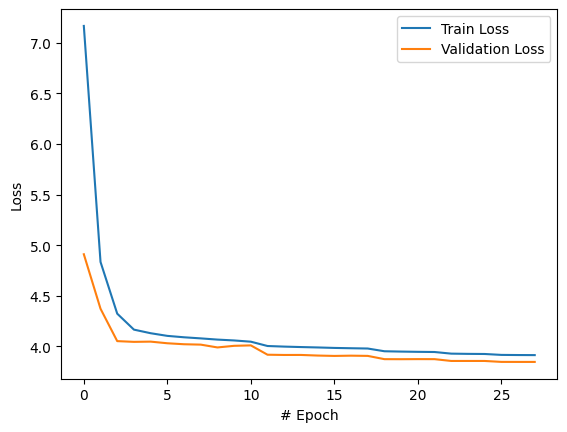

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8448960597499595 to 3.842940749677293
Epoch:  29/50 | Training pTLoss:  3.907610542862121 | Testing pTLoss:  3.842940749677293


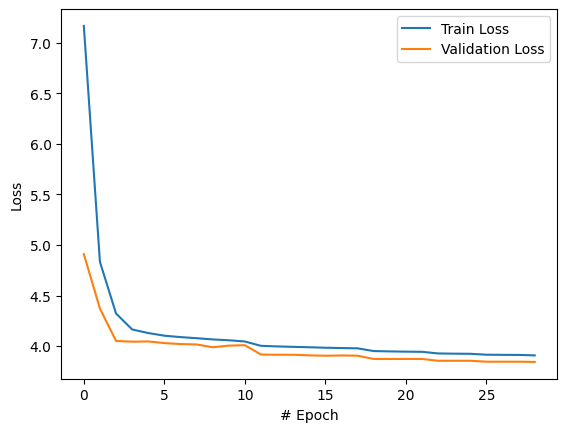

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.842940749677293 to 3.8427669872689374
Epoch:  30/50 | Training pTLoss:  3.9066991575886525 | Testing pTLoss:  3.8427669872689374


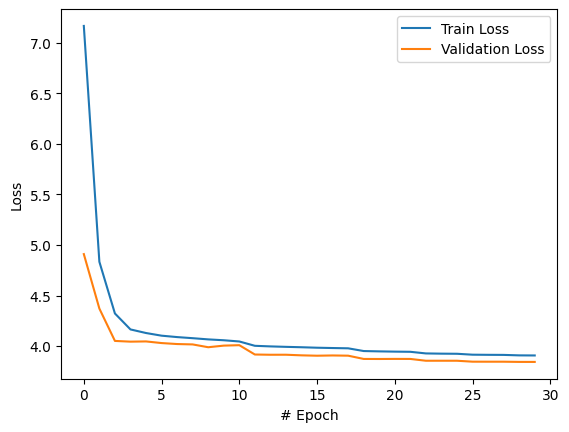

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8427669872689374 to 3.842614719252264
Epoch 00031: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  31/50 | Training pTLoss:  3.9063064426248273 | Testing pTLoss:  3.842614719252264


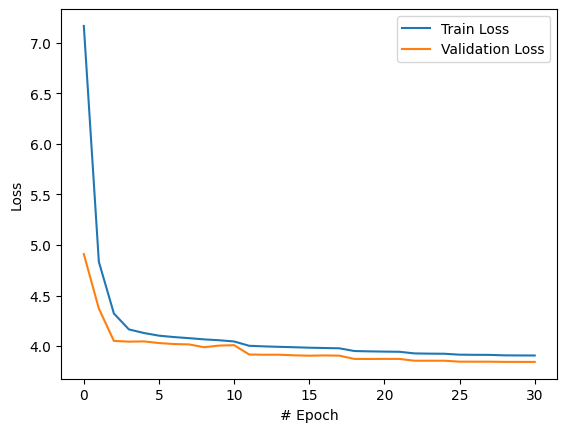

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.842614719252264 to 3.8422568692561136
Epoch:  32/50 | Training pTLoss:  3.9040216308353743 | Testing pTLoss:  3.8422568692561136


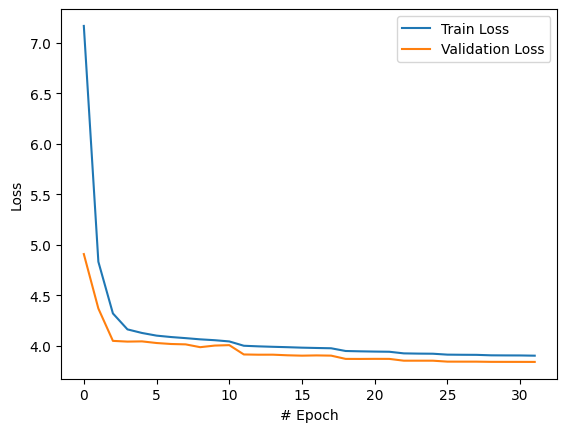

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8422568692561136 to 3.8421572501126717
Epoch:  33/50 | Training pTLoss:  3.9033785233528646 | Testing pTLoss:  3.8421572501126717


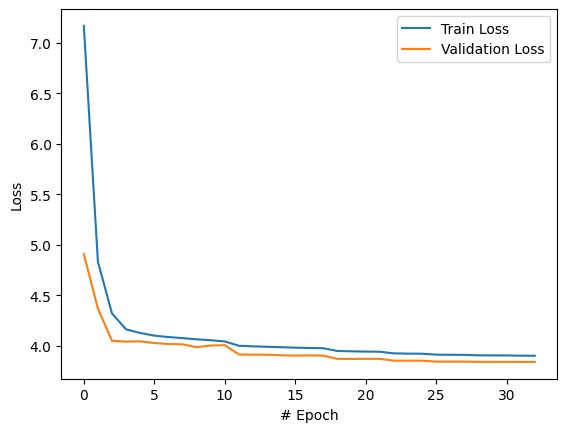

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8421572501126717 to 3.8421203694478043
Epoch 00034: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  34/50 | Training pTLoss:  3.9031513453564215 | Testing pTLoss:  3.8421203694478043


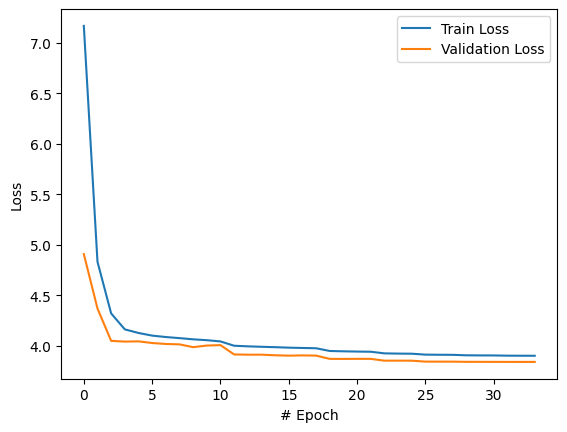

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8421203694478043 to 3.8411251016914734
Epoch:  35/50 | Training pTLoss:  3.901885026447679 | Testing pTLoss:  3.8411251016914734


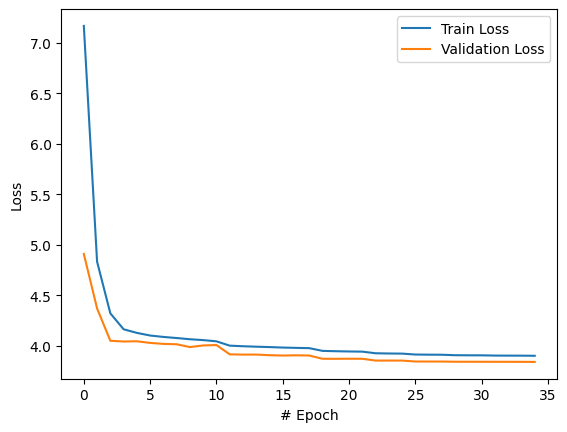

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8411251016914734 to 3.8410910841182595
Epoch:  36/50 | Training pTLoss:  3.901584849957528 | Testing pTLoss:  3.8410910841182595


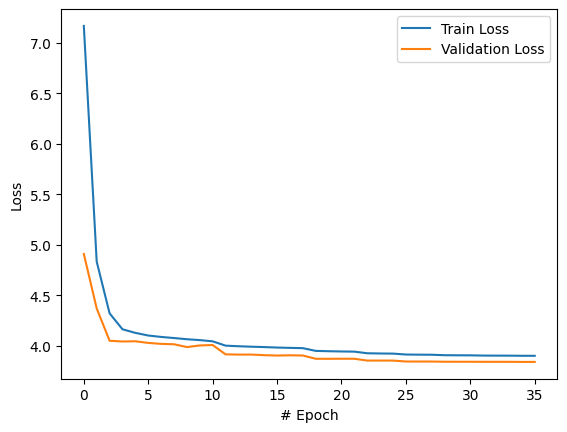

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8410910841182595 to 3.841072937154459
Epoch 00037: reducing learning rate of group 0 to 3.9063e-06.
Epoch:  37/50 | Training pTLoss:  3.9014693960191855 | Testing pTLoss:  3.841072937154459


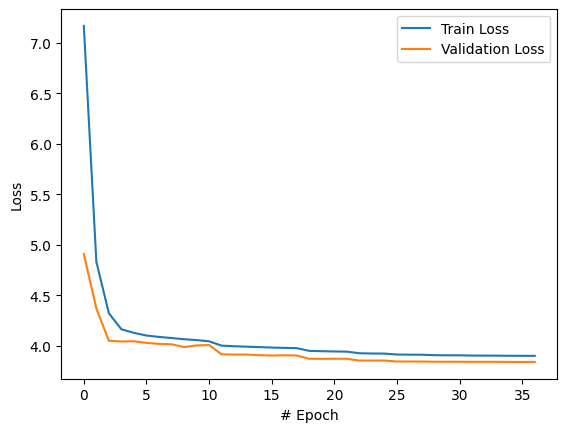

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.841072937154459 to 3.839816208516698
Epoch:  38/50 | Training pTLoss:  3.9007666347600862 | Testing pTLoss:  3.839816208516698


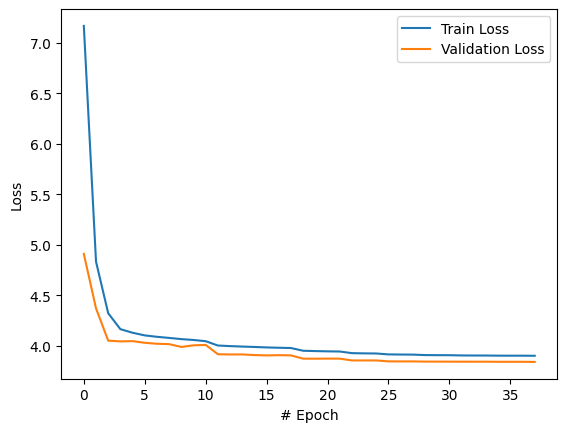

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.839816208516698 to 3.839797107619993
Epoch:  39/50 | Training pTLoss:  3.900648987732844 | Testing pTLoss:  3.839797107619993


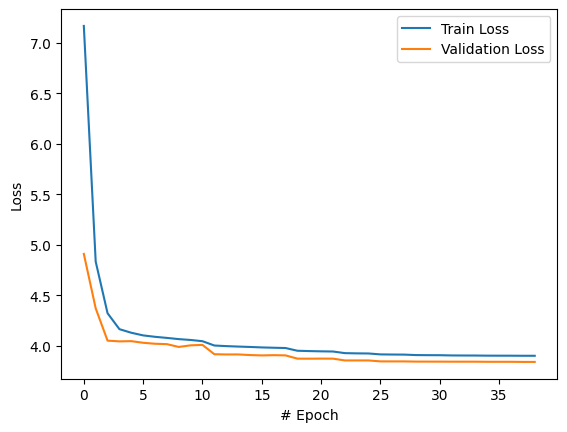

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00040: reducing learning rate of group 0 to 1.9531e-06.
Epoch:  40/50 | Training pTLoss:  3.900582938416659 | Testing pTLoss:  3.8398063842231407


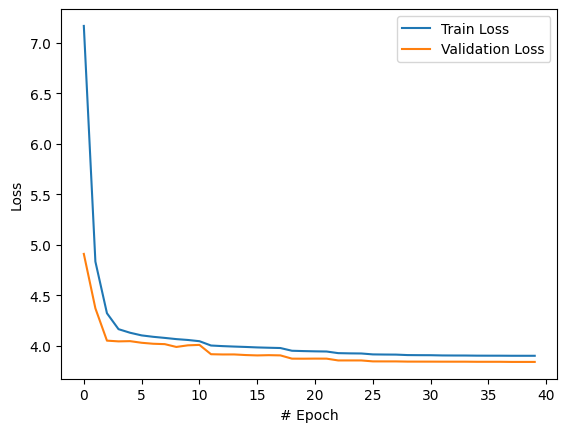

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.839797107619993 to 3.8393621134395994
Epoch:  41/50 | Training pTLoss:  3.9001880152365143 | Testing pTLoss:  3.8393621134395994


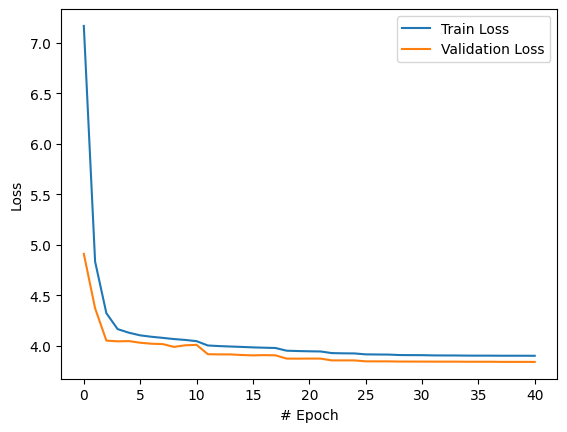

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8393621134395994 to 3.8393200547989936
Epoch:  42/50 | Training pTLoss:  3.9001449779678046 | Testing pTLoss:  3.8393200547989936


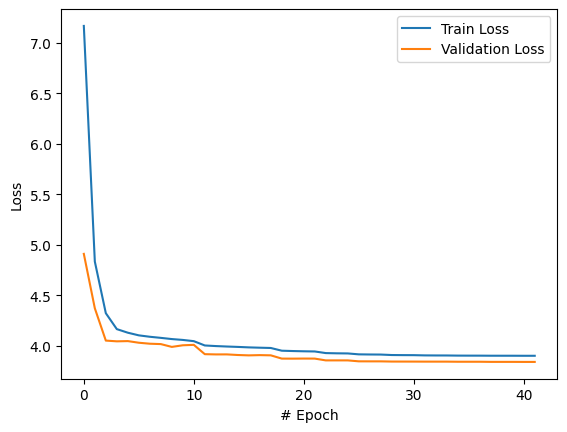

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8393200547989936 to 3.839312660461393
Epoch 00043: reducing learning rate of group 0 to 9.7656e-07.
Epoch:  43/50 | Training pTLoss:  3.900114582831326 | Testing pTLoss:  3.839312660461393


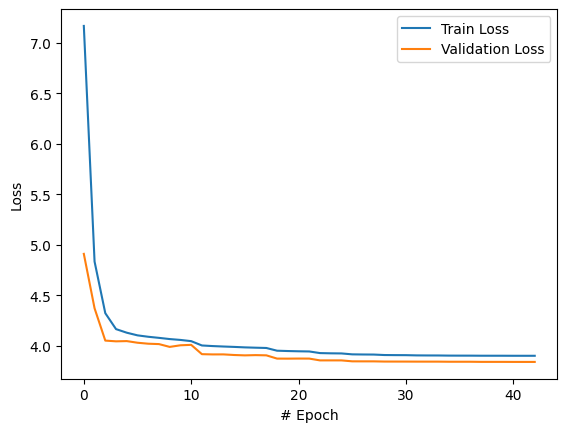

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.839312660461393 to 3.8392484689741484
Epoch:  44/50 | Training pTLoss:  3.8998893871741775 | Testing pTLoss:  3.8392484689741484


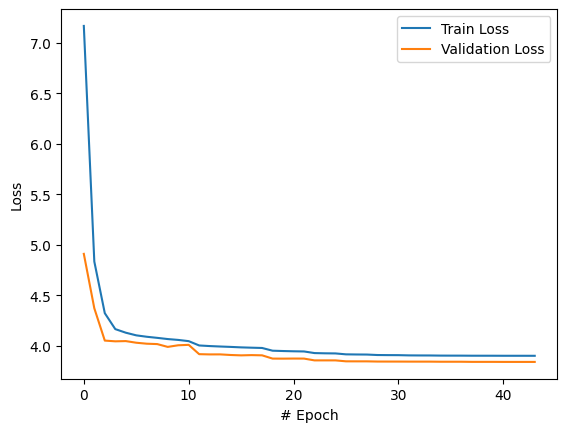

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8392484689741484 to 3.8392310483853915
Epoch 00045: reducing learning rate of group 0 to 4.8828e-07.
Epoch:  45/50 | Training pTLoss:  3.8998722180627223 | Testing pTLoss:  3.8392310483853915


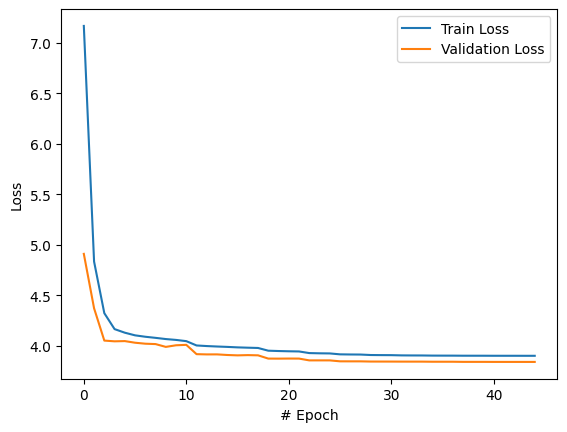

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8392310483853915 to 3.839226656777222
Epoch:  46/50 | Training pTLoss:  3.8997504620645147 | Testing pTLoss:  3.839226656777222


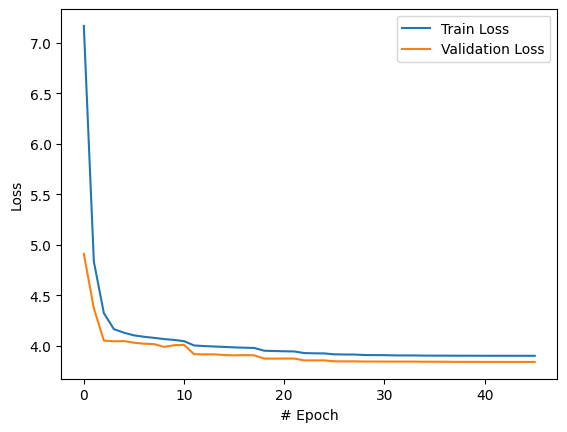

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.839226656777222 to 3.8392254820097538
Epoch 00047: reducing learning rate of group 0 to 2.4414e-07.
Epoch:  47/50 | Training pTLoss:  3.899742629807318 | Testing pTLoss:  3.8392254820097538


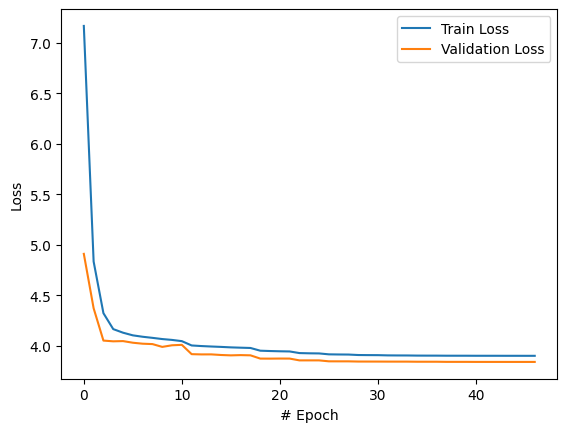

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  48/50 | Training pTLoss:  3.899679237358481 | Testing pTLoss:  3.839227357552004


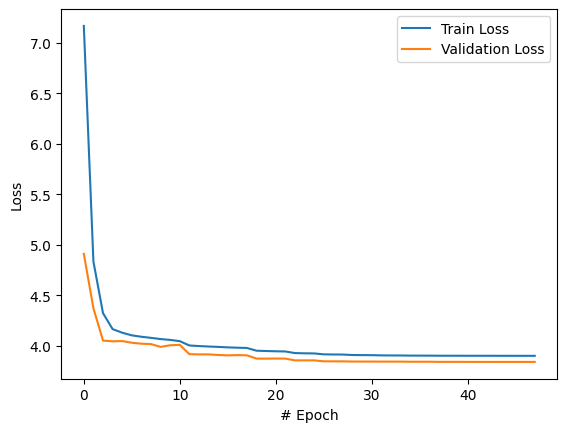

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00049: reducing learning rate of group 0 to 1.2207e-07.
Epoch:  49/50 | Training pTLoss:  3.899675461061605 | Testing pTLoss:  3.8392288253002196


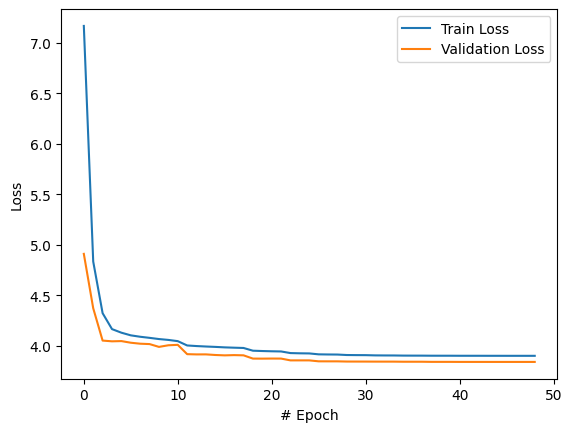

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  50/50 | Training pTLoss:  3.8996427097961877 | Testing pTLoss:  3.8392305668936384


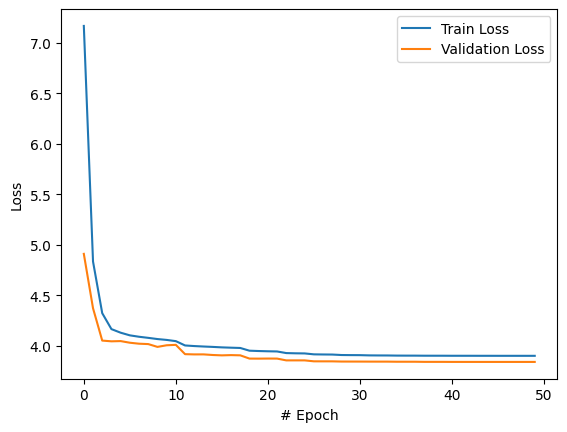

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
model = MODEL_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
os.makedirs("/kaggle/working/model_trained" , exist_ok =True)
train_losses, test_losses = train(train_loader, test_loader, prog_bar=True)

# TESTING

In [31]:
model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = MODEL_GNN().to(device)
loaded_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [32]:
test_los = 0
preds = []
true_labels = []
# criterion = nn.MSELoss()
for data in tqdm(test_loader, position=0):
    data = data.to(device)
    out = model(data)
    preds.append(out.cpu().detach().numpy())
    labels = data.y.cpu().detach().numpy()
    true_labels.append(labels)
    loss = pTLossTorch(out, data.y)
    test_los += loss.item() / len(test_loader)

# Convert lists to numpy arrays
preds = np.concatenate(preds, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate R2 score
r2 = r2_score(true_labels, preds)

print('Test Loss:', test_los)
print('R2 Score:', r2)

  0%|          | 0/461 [00:00<?, ?it/s]

Test Loss: 3.8392305689623454
R2 Score: -0.03542662831208876
